# Imports and load Data

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from catboost import CatBoostRegressor, Pool, cv
import xgboost as xgb
from xgboost import XGBRegressor, DMatrix
import lightgbm as lgb
from lightgbm import LGBMRegressor, Dataset

from hyperopt import hp, fmin, STATUS_OK, STATUS_FAIL, tpe, Trials, space_eval

pd.set_option('display.max_rows', 100)

In [6]:
df = pd.read_csv('./data/train_trees.csv')
test_df = pd.read_csv('./data/test_trees.csv')
df.head()

,rent_approval_date,town,block,street_name,flat_type,flat_model,floor_area_sqm,furnished,lease_commence_date,latitude,...,num_top_sch_2km,num_good_sch_1km,num_good_sch_2km,num_normal_sch_1km,num_normal_sch_2km,age,age_bin,shortest_dist_mall,shortest_ex_mrt,shortest_pl_mrt
0,2021-09-01,jurong east,257,Jurong East Street 24,3 room,new generation,67.0,yes,1983-01-01,1.344518,...,1,0,2,2,4,38.693151,6,1.202674,0.699127,0.699127
1,2022-05-01,bedok,119,bedok north road,4 room,new generation,92.0,yes,1978-01-01,1.330186,...,2,1,1,3,6,44.358904,7,1.114338,0.898991,0.898991
2,2022-10-01,toa payoh,157,lorong 1 toa payoh,3 room,improved,67.0,yes,1971-01-01,1.332242,...,4,0,1,1,3,51.783562,9,0.468297,0.218603,0.218603
3,2021-08-01,pasir ris,250,Pasir Ris Street 21,executive,apartment,149.0,yes,1993-01-01,1.370239,...,0,2,2,1,4,28.600000,4,0.402359,1.546040,1.546040
4,2022-11-01,kallang/whampoa,34,Whampoa West,3 room,improved,68.0,yes,1972-01-01,1.320502,...,1,0,1,1,2,50.868493,8,1.073354,0.187856,0.187856


In [51]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
train_df.shape, val_df.shape

((47781, 32), (11946, 32))

In [52]:
all_cols = ['town', 'flat_type', 'flat_model', 'subzone', 'planning_area', 'region',
            'num_top_sch_1km', 'num_top_sch_2km', 'num_good_sch_1km', 'num_good_sch_2km', 'num_normal_sch_1km', 'num_normal_sch_2km',
            'age_bin', 'age', 'floor_area_sqm', 'shortest_dist_school', 'shortest_dist_mall', 'shortest_ex_mrt', 'shortest_pl_mrt', 'sti', 'coe']
y_col = ['monthly_rent']
train_df = train_df[all_cols + y_col]
test_df = test_df[all_cols]
print(len(all_cols))
train_df.head()

21


,town,flat_type,flat_model,subzone,planning_area,region,num_top_sch_1km,num_top_sch_2km,num_good_sch_1km,num_good_sch_2km,...,age_bin,age,floor_area_sqm,shortest_dist_school,shortest_dist_mall,shortest_ex_mrt,shortest_pl_mrt,sti,coe,monthly_rent
5685,tampines,3 room,new generation,tampines east,tampines,east region,1,3,2,2,...,6,38.441096,67.0,0.418494,0.280861,0.515867,0.515867,0.665652,0.715263,1950
32944,tampines,4 room,new generation,tampines east,tampines,east region,1,3,2,2,...,6,36.271233,93.0,0.607227,0.170779,0.504642,0.504642,0.561993,0.126418,2150
51177,jurong east,5 room,improved,toh guan,jurong east,west region,0,1,0,1,...,4,24.430137,121.0,0.672904,0.560762,0.873512,0.873512,0.665652,0.715263,2900
6956,sengkang,4 room,premium apartment,compassvale,sengkang,north-east region,2,4,1,5,...,2,14.504110,90.0,0.219147,0.307330,0.236640,0.236640,0.602295,0.961789,3700
3296,central,4 room,type s1,chinatown,outram,central region,0,0,0,1,...,1,10.336986,95.0,0.148131,0.297282,0.489754,0.489754,0.622854,0.195823,3550


In [53]:
cat_cols = ['town', 'flat_type', 'flat_model', 'subzone', 'planning_area', 'region', 'age_bin',
            'num_top_sch_1km', 'num_top_sch_2km', 'num_good_sch_1km', 'num_good_sch_2km', 'num_normal_sch_1km', 'num_normal_sch_2km']
train_df[cat_cols] = train_df[cat_cols].astype('category')
val_df[cat_cols] = val_df[cat_cols].astype('category')
test_df[cat_cols] = test_df[cat_cols].astype('category')

# Hyperopt setup

In [54]:
num_evals = 100
device = 'gpu'

#common hyperparameters sets for all models
n_estimators = [50, 100, 200, 300]
max_depth = [2, 3, 4, 5, 7, 10, 12]
learning_rate = [0.01, 0.05, 0.1, 0.2, 0.5, 0.75, 1.0]
subsample = [0.4, 0.6, 0.8, 0.9, 1.0]
col_subsample = [0.4, 0.6, 0.8, 0.9, 1.0] # cannot use for catboost when using GPU
# col_subsample = [1.0]

### Class object for hyperparameter optimisation

In [55]:
class HPOptimiser(object):
    def __init__(self, train_pool, val_pool, train_labels=None, val_labels=None):
        self.train_pool = train_pool
        self.val_pool = val_pool
        self.train_labels = train_labels
        self.val_labels = val_labels

    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
        except Exception as e:
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        return result, trials

    def catboost_reg(self, para):
        reg = CatBoostRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def train_reg(self, reg, params):
        reg.fit(self.train_pool,
                eval_set=self.val_pool,
                **params['fit_params'])
        pred = reg.predict(self.val_pool)
        loss = np.sqrt(mean_squared_error(self.val_pool.get_label(), pred))
        return {'loss': loss, 'status': STATUS_OK}

    def xgboost_reg(self, para):
        reg = xgb.train(params=para['reg_params'], dtrain=self.train_pool, evals=[(self.val_pool, 'eval')], **para['fit_params'])
        pred = reg.predict(self.val_pool)
        loss = np.sqrt(mean_squared_error(self.val_pool.get_label(), pred))
        return {'loss': loss, 'status': STATUS_OK}

    def lightgbm_reg(self, para):
        reg = lgb.train(para['reg_params'], self.train_pool, **para['fit_params'])
        pred = reg.predict(self.val_pool.get_data().loc[:,:])
        loss = np.sqrt(mean_squared_error(self.val_pool.get_label().copy(), pred))
        return {'loss': loss, 'status': STATUS_OK}

# Catboost

In [59]:
# Choose which subset of columns to use with the categorical columns first then set n_cat_cols to the number of categorical columns

# x_col = ['town', 'flat_type', 'flat_model', 'subzone', 'planning_area', 'region',
#          'num_top_sch_1km', 'num_top_sch_2km', 'num_good_sch_1km', 'num_good_sch_2km', 'num_normal_sch_1km', 'num_normal_sch_2km',
#          'age_bin', 'age', 'floor_area_sqm', 'shortest_dist_school', 'shortest_dist_mall', 'shortest_ex_mrt', 'shortest_pl_mrt', 'sti', 'coe', 'hdb_index']
# n_cat_cols = 13

x_col = ['flat_type', 'subzone', 'region',
         'age', 'floor_area_sqm', 'shortest_dist_school', 'shortest_dist_mall', 'shortest_ex_mrt', 'shortest_pl_mrt', 'sti', 'coe']
n_cat_cols = 3

### Test run before optimisation of hyperparameters

In [75]:

train_pool = Pool(train_df[x_col], train_df[y_col], cat_features=np.arange(n_cat_cols))
val_pool = Pool(val_df[x_col], val_df[y_col], cat_features=np.arange(n_cat_cols))
test_pool = Pool(test_df[x_col], cat_features=np.arange(n_cat_cols))

cat_model = CatBoostRegressor(iterations=2000,
                          depth=5,
                          learning_rate=0.2,
                          bootstrap_type='MVS',
                        #   subsample=0.8,
                          loss_function='RMSE',
                          boosting_type='Ordered',
                          task_type='GPU')
# train the model
cat_model.fit(train_pool, plot=True, eval_set=val_pool)

# evaluate on validation set
preds = cat_model.predict(val_pool)
print(f'RMSE on validation set is {np.sqrt(mean_squared_error(val_df[y_col], preds))}')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 657.6377095	test: 655.1838217	best: 655.1838217 (0)	total: 22.4ms	remaining: 44.7s
1:	learn: 656.6969373	test: 654.4666329	best: 654.4666329 (1)	total: 41.5ms	remaining: 41.4s
2:	learn: 655.4923297	test: 653.0011449	best: 653.0011449 (2)	total: 51.8ms	remaining: 34.5s
3:	learn: 654.0260989	test: 651.3209995	best: 651.3209995 (3)	total: 69.1ms	remaining: 34.5s
4:	learn: 653.1218312	test: 650.3653506	best: 650.3653506 (4)	total: 85.9ms	remaining: 34.3s
5:	learn: 647.6099172	test: 645.5239593	best: 645.5239593 (5)	total: 103ms	remaining: 34.1s
6:	learn: 647.1363209	test: 645.0497915	best: 645.0497915 (6)	total: 125ms	remaining: 35.6s
7:	learn: 646.6995942	test: 644.5942251	best: 644.5942251 (7)	total: 145ms	remaining: 36.1s
8:	learn: 646.0505021	test: 643.9366622	best: 643.9366622 (8)	total: 171ms	remaining: 37.8s
9:	learn: 645.8559493	test: 643.7611232	best: 643.7611232 (9)	total: 187ms	remaining: 37.3s
10:	learn: 645.8015940	test: 643.6953087	best: 643.6953087 (10)	total: 204m

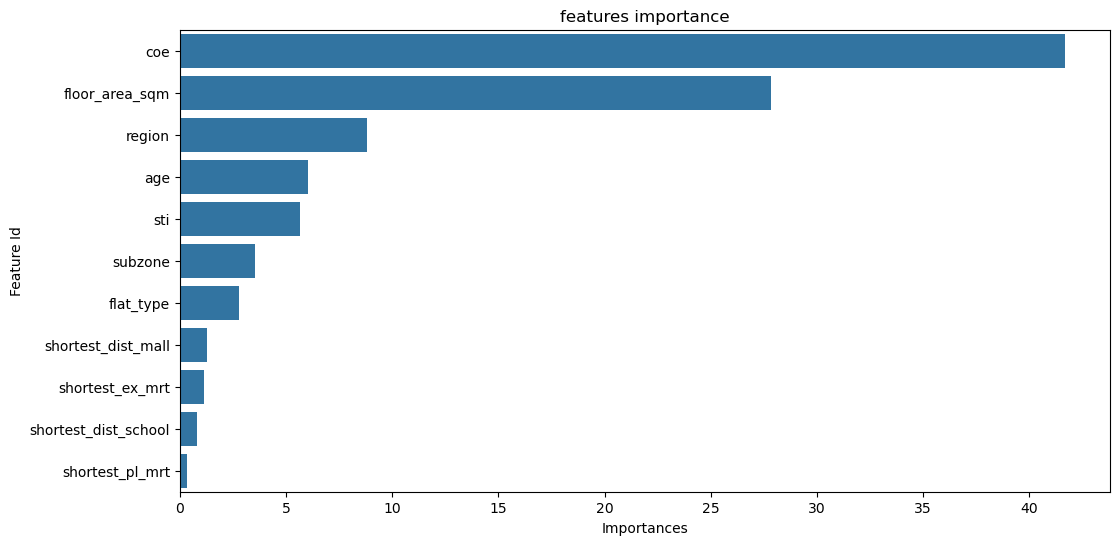

In [14]:
# Create a dataframe of feature importance
df_feature_importance = pd.DataFrame(cat_model.get_feature_importance(prettified=True))
#plotting feature importance
plt.figure(figsize=(12, 6));
feature_plot= sns.barplot(x="Importances", y="Feature Id", data=df_feature_importance);
plt.title('features importance');

### Hyperparameter optimisation

In [15]:
# Catboost hyperparameters to search
catboost_hyperparams = { 'n_estimators': hp.choice('n_estimators', n_estimators),
                         'max_depth': hp.choice('max_depth', max_depth),
                         'learning_rate': hp.choice('learning_rate', learning_rate),
                         'subsample': hp.choice('subsample', subsample),
                        #  'colsample_bylevel': hp.choice('colsample_bylevel', col_subsample),
                         'bootstrap_type': hp.choice('bootstrap_type', ['Poisson', 'Bernoulli', 'MVS']),
                         'l2_leaf_reg': hp.uniform('l2_leaf_reg', 0., 10),
                         'boosting_type': hp.choice('boosting_type', ['Ordered', 'Plain']),
                         'loss_function': 'RMSE',
                         'eval_metric': 'RMSE',
                         'task_type': device.upper()}

catboost_fit_params = {'early_stopping_rounds': 10, 'verbose': False}

catboost_params = dict()
catboost_params['reg_params'] = catboost_hyperparams
catboost_params['fit_params'] = catboost_fit_params
catboost_params['loss_func'] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))

In [16]:
# hyperparamter optimisation
optimiser = HPOptimiser(train_pool, val_pool)
catboost_opt = optimiser.process(fn_name='catboost_reg', space=catboost_params,
                          trials=Trials(), algo=tpe.suggest, max_evals=num_evals)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 100/100 [03:26<00:00,  2.07s/trial, best loss: 484.23889905460567]


In [17]:
# get best params
catboost_reg_params = space_eval(catboost_params['reg_params'], catboost_opt[0])
catboost_fit_params = space_eval(catboost_params['fit_params'], catboost_opt[0])
print(catboost_reg_params)
print(catboost_fit_params)

{'bootstrap_type': 'Bernoulli', 'eval_metric': 'RMSE', 'l2_leaf_reg': 10, 'learning_rate': 0.05, 'loss_function': 'RMSE', 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.6, 'task_type': 'GPU'}
{'early_stopping_rounds': 10, 'verbose': False}


In [18]:
# get the best model
cat_model = CatBoostRegressor(**catboost_reg_params)
cat_model.fit(train_pool, plot=True, **catboost_fit_params)
preds = cat_model.predict(val_pool)
print(f'RMSE on validation set is {np.sqrt(mean_squared_error(val_df[y_col], preds))}')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

RMSE on validation set is 484.56131143593495


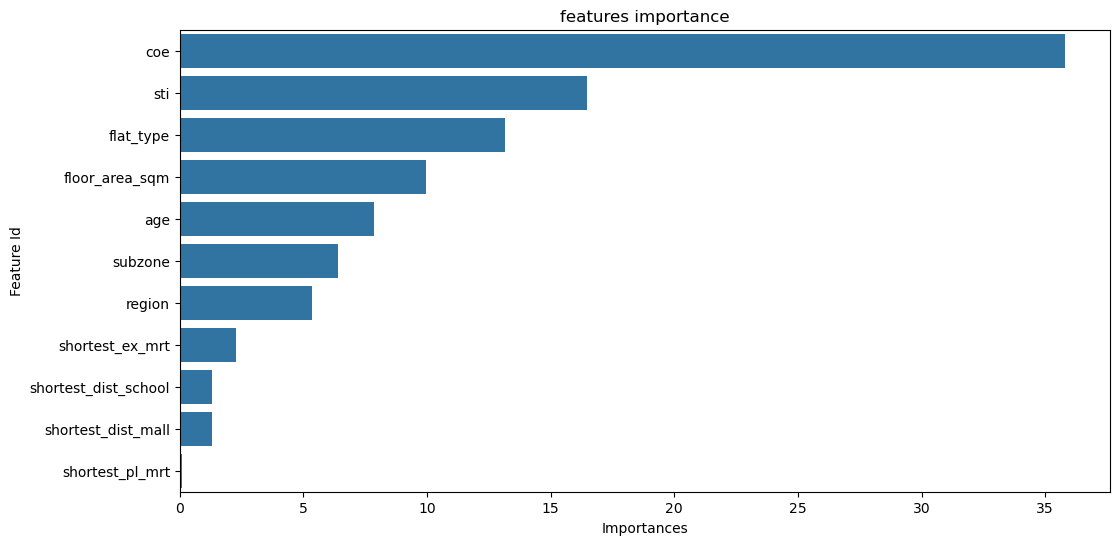

In [76]:
# Create a dataframe of feature importance
df_feature_importance = pd.DataFrame(cat_model.get_feature_importance(prettified=True))
#plotting feature importance
plt.figure(figsize=(12, 6));
feature_plot= sns.barplot(x="Importances", y="Feature Id", data=df_feature_importance);
plt.title('features importance');

In [77]:
# predict on test set
preds = cat_model.predict(test_pool)
preds

array([3186.36820892, 2946.67872387, 2942.71170302, ..., 2932.41992653,
       3314.38836859, 3653.18189841])

In [78]:
# output to csv
submission_df = pd.DataFrame({'Predicted': preds})
submission_df.rename_axis('Id', inplace=True)
submission_df.to_csv('./data/submission_catboost.csv')

# XGBoost

In [22]:
# Choose which subset of columns to use

# x_col = ['town', 'flat_type', 'flat_model', 'subzone', 'planning_area', 'region',
#          'num_top_sch_1km', 'num_top_sch_2km', 'num_good_sch_1km', 'num_good_sch_2km', 'num_normal_sch_1km', 'num_normal_sch_2km',
#          'age_bin', 'age', 'floor_area_sqm', 'shortest_dist_school', 'shortest_dist_mall', 'shortest_ex_mrt', 'shortest_pl_mrt', 'sti', 'coe', 'hdb_index']

x_col = ['flat_type', 'subzone', 'region',
         'age', 'floor_area_sqm', 'shortest_dist_school', 'shortest_dist_mall', 'shortest_ex_mrt', 'shortest_pl_mrt', 'sti', 'coe']

### Test run before optimisation of hyperparameters

In [23]:
dtrain = DMatrix(data=train_df[x_col], label=train_df[y_col], enable_categorical=True)
params = {'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'booster': 'gbtree', 'device': 'gpu'}
xgb_cv = xgb.cv(params=params, dtrain=dtrain, num_boost_round=100, nfold=5, early_stopping_rounds=10, verbose_eval=10)
xgb_cv

[0]	train-rmse:614.10533+0.95445	test-rmse:617.23824+5.43227
[10]	train-rmse:464.19849+0.89879	test-rmse:492.62856+2.07948
[20]	train-rmse:449.53435+0.64588	test-rmse:492.47628+2.09523
[23]	train-rmse:446.64760+0.62737	test-rmse:492.82733+1.94380


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,614.105327,0.954454,617.238237,5.432269
1,555.806122,1.058076,561.965814,4.906374
2,522.117109,0.854547,530.902745,4.665124
3,502.570639,0.830360,514.190268,4.227872
4,490.536696,1.015997,504.866476,3.665142
5,482.616067,0.999183,499.617644,3.104614
6,477.178100,0.848642,496.112495,2.801013
7,472.958478,0.593326,494.614866,2.511095
8,469.038971,0.615428,493.582327,2.146656
9,466.411224,0.868356,493.046574,2.092528


In [24]:
val_df[cat_cols] = val_df[cat_cols].astype('category')
deval = DMatrix(data=val_df[x_col], label=val_df[y_col], enable_categorical=True)
xgb_model = xgb.train(params=params, dtrain=dtrain, num_boost_round=100, early_stopping_rounds=10, evals=[(dtrain, 'train'), (deval, 'eval')], verbose_eval=10)

[0]	train-rmse:614.66187	eval-rmse:631.81167
[10]	train-rmse:468.15850	eval-rmse:539.07481
[18]	train-rmse:457.69558	eval-rmse:541.19571


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

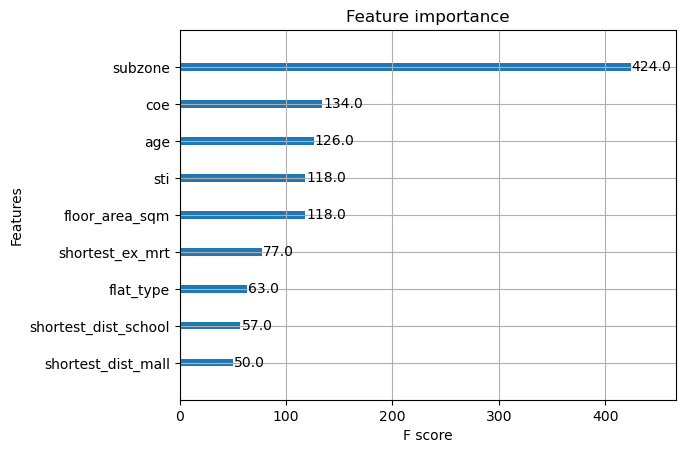

In [25]:
xgb.plot_importance(xgb_model, max_num_features=20)

### Hyperparamter optimisation

In [26]:
# xgboost hyperparameters to search
xgboost_hyperparams = { 'max_depth': hp.choice('max_depth', max_depth),
                        'learning_rate': hp.choice('learning_rate', learning_rate),
                        'subsample': hp.choice('subsample', subsample),
                        'colsample_bytree': hp.choice('colsample_bytree', subsample),
                        # 'gamma': hp.uniform ('gamma', 0, 10),
                        # 'reg_alpha': hp.quniform('reg_alpha', 20, 100, 1),
                        # 'reg_lambda': hp.uniform('reg_lambda', 0, 1),
                        'booster': 'gbtree',
                        'objective': 'reg:squarederror',
                        'eval_metric': 'rmse',
                        'device': device}

xgboost_fit_params = {'early_stopping_rounds': 10,
                      'num_boost_round': hp.choice('num_boost_round', n_estimators),
                      'verbose_eval': False}

xgboost_params = dict()
xgboost_params['reg_params'] = xgboost_hyperparams
xgboost_params['fit_params'] = xgboost_fit_params
xgboost_params['loss_func'] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))

In [27]:
# hyperparamter optimisation
optimiser = HPOptimiser(dtrain, deval)
xgboost_opt = optimiser.process(fn_name='xgboost_reg', space=xgboost_params,
                          trials=Trials(), algo=tpe.suggest, max_evals=num_evals)

100%|██████████| 100/100 [01:20<00:00,  1.24trial/s, best loss: 504.51129150390625]


In [28]:
# get best params
xgboost_reg_params = space_eval(xgboost_params['reg_params'], xgboost_opt[0])
xgboost_fit_params = space_eval(xgboost_params['fit_params'], xgboost_opt[0])
print(xgboost_reg_params)
print(xgboost_fit_params)

{'booster': 'gbtree', 'colsample_bytree': 0.4, 'device': 'gpu', 'eval_metric': 'rmse', 'learning_rate': 0.05, 'max_depth': 5, 'objective': 'reg:squarederror', 'subsample': 0.6}
{'early_stopping_rounds': 10, 'num_boost_round': 300, 'verbose_eval': False}


In [29]:
# use best params to train XGBoost
xgb_model = xgb.train(params=xgboost_reg_params, dtrain=dtrain,
                      evals=[(deval, 'eval')],
                      num_boost_round=xgboost_fit_params['num_boost_round'],
                      early_stopping_rounds=xgboost_fit_params['early_stopping_rounds'],
                      verbose_eval=10)
preds = xgb_model.predict(deval)
print(f'RMSE on validation set is {np.sqrt(mean_squared_error(val_df[y_col], preds))}')

[0]	eval-rmse:707.70941


[10]	eval-rmse:625.40934
[20]	eval-rmse:570.89116
[30]	eval-rmse:544.40684
[40]	eval-rmse:529.81539
[50]	eval-rmse:520.94928
[60]	eval-rmse:515.96587
[70]	eval-rmse:511.44490
[80]	eval-rmse:509.06413
[90]	eval-rmse:507.58369
[100]	eval-rmse:507.09551
[110]	eval-rmse:506.35472
[120]	eval-rmse:505.63858
[130]	eval-rmse:505.07055
[140]	eval-rmse:504.51549
[150]	eval-rmse:504.48420
[160]	eval-rmse:504.48138
[164]	eval-rmse:504.51128
RMSE on validation set is 504.51129976628016


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

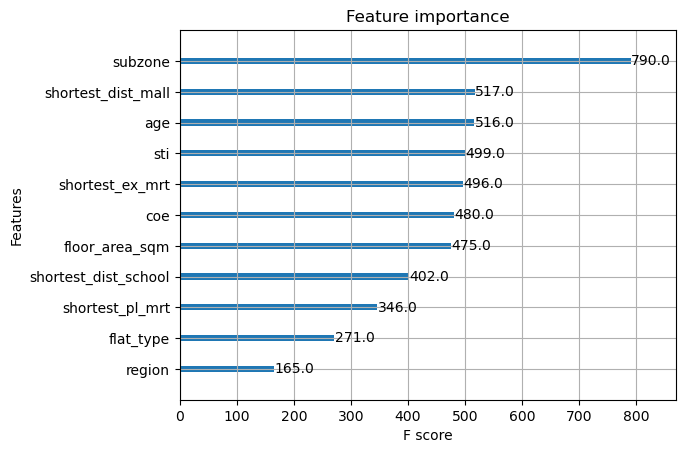

In [30]:
xgb.plot_importance(xgb_model, max_num_features=20)

In [31]:
# predict on test set
dtest = DMatrix(data=test_df[x_col], enable_categorical=True)
preds = xgb_model.predict(dtest)
preds

array([3345.04  , 2903.08  , 3659.9546, ..., 3248.7104, 3233.4038,
       3588.9724], dtype=float32)

In [32]:
# output to csv
submission_df = pd.DataFrame({'Predicted': preds})
submission_df.rename_axis('Id', inplace=True)
submission_df.to_csv('./data/submission_xgboost.csv')

# LightGBM

In [33]:
# Choose which subset of columns to use

# x_col = ['town', 'flat_type', 'flat_model', 'subzone', 'planning_area', 'region',
#          'num_top_sch_1km', 'num_top_sch_2km', 'num_good_sch_1km', 'num_good_sch_2km', 'num_normal_sch_1km', 'num_normal_sch_2km',
#          'age_bin', 'age', 'floor_area_sqm', 'shortest_dist_school', 'shortest_dist_mall', 'shortest_ex_mrt', 'shortest_pl_mrt', 'sti', 'coe', 'hdb_index']

x_col = ['flat_type', 'subzone', 'region',
         'age', 'floor_area_sqm', 'shortest_dist_school', 'shortest_dist_mall', 'shortest_ex_mrt', 'shortest_pl_mrt', 'sti', 'coe']

In [34]:
lgb_train = Dataset(train_df[x_col], train_df[y_col], params={'verbose': -1}, free_raw_data=False).construct()
lgb_eval = Dataset(val_df[x_col], val_df[y_col], params={'verbose': -1}, free_raw_data=False).construct()

In [44]:
# lightgbm hyperparameters to search
lightgbm_hyperparams = {'max_depth': hp.choice('max_depth', max_depth),
                        'learning_rate': hp.choice('learning_rate', learning_rate),
                        'subsample': hp.choice('subsample', subsample),
                        'colsample_bytree': hp.choice('colsample_bytree', col_subsample),
                        'max_bin': hp.choice('max_bin', [32, 64, 128, 256]),
                        'num_leaves': hp.choice('num_leaves', [2, 4, 8, 16, 32, 64, 128]),
                        'min_data_in_leaf': hp.choice('min_data_in_leaf', [2, 4, 8, 16, 32, 64, 128]),
                        'gamma': hp.uniform ('gamma', 0, 10),
                        'reg_alpha': hp.quniform('reg_alpha', 20, 100, 1),
                        'reg_lambda': hp.uniform('reg_lambda', 0, 1),
                        'objective': 'regression',
                        'metric': 'rmse',
                        'device': device,
                        'verbose': -1}

lightgbm_fit_params = {'num_boost_round': hp.choice('num_boost_round', n_estimators)}#, 'verbose_eval': False}

lightgbm_params = dict()
lightgbm_params['reg_params'] = lightgbm_hyperparams
lightgbm_params['fit_params'] = lightgbm_fit_params
lightgbm_params['loss_func'] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))

In [45]:
# hyperparamter optimisation
optimiser = HPOptimiser(lgb_train, lgb_eval)
lightgbm_opt = optimiser.process(fn_name='lightgbm_reg', space=lightgbm_params,
                          trials=Trials(), algo=tpe.suggest, max_evals=num_evals)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 100/100 [01:01<00:00,  1.62trial/s, best loss: 483.7700037970634]


In [46]:
# get best params
lgb_reg_params = space_eval(lightgbm_params['reg_params'], lightgbm_opt[0])
lgb_fit_params = space_eval(lightgbm_params['fit_params'], lightgbm_opt[0])
print(lgb_reg_params)
print(lgb_fit_params)

{'colsample_bytree': 1.0, 'device': 'gpu', 'gamma': 4.805409720701174, 'learning_rate': 0.1, 'max_bin': 64, 'max_depth': 5, 'metric': 'rmse', 'min_data_in_leaf': 4, 'num_leaves': 8, 'objective': 'regression', 'reg_alpha': 65.0, 'reg_lambda': 0.5030756369275491, 'subsample': 1.0, 'verbose': -1}
{'num_boost_round': 200}


In [47]:
# get the best model
lgb_model = lgb.train(lgb_reg_params, lgb_train, **lgb_fit_params)
preds = lgb_model.predict(val_df.loc[:,x_col])
print(f'RMSE on validation set is {np.sqrt(mean_squared_error(val_df[y_col], preds))}')

RMSE on validation set is 483.77000375821683


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

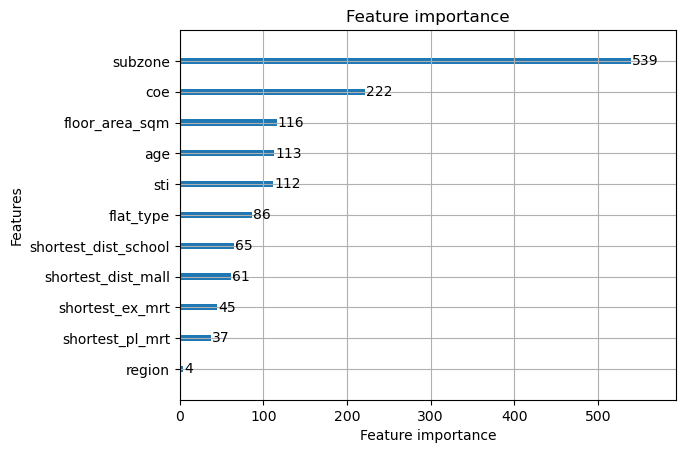

In [48]:
lgb.plot_importance(lgb_model, max_num_features=20)

In [49]:
# predict on test set
preds = lgb_model.predict(test_df.loc[:,x_col])
preds

array([2556.95930919, 2368.32135163, 2879.32499031, ..., 2467.96297119,
       3291.68389117, 2829.97608914])

In [50]:
# output to csv
submission_df = pd.DataFrame({'Predicted': preds})
submission_df.rename_axis('Id', inplace=True)
submission_df.to_csv('./data/submission_lightgbm.csv')